#Fitbit Sense: Guide to data extraction and analysis

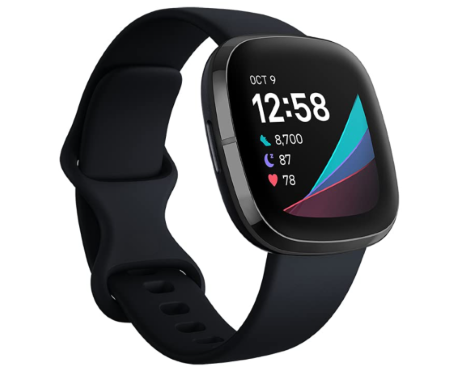

A picture of the Fitbit Sense

At a price of around 250$, the [Fitbit Sense](https://www.fitbit.com/global/us/products/smartwatches/sense) is a sleep and physical activity tracker that tracks stress, exercise, ECG, SpO2 and more!

This is a comprehensive, clear guide to extract data from the Fitbit Sense using the Fitbit Web API. Links to external resources and official Fitbit documentation are provided throughout the guide for further reference.

If you want to know more about the Fitbit Sense, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/fitbit-Sense) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.


A list of the most important accessible data categories is provided below, For the full list, access the api data in section 3.

Category Name (API version)| Parameter Name (subcategory)| Frequency of Sampling
:-------------------:|:----------------------:|:----------------------:
sleep | date |during the night
sleep | duration |during the night
sleep | efficiency |during the night
sleep | end time |during the night
sleep | sleep levels |during the night
steps | date and time |daily
steps | value (number of steps) |daily
minutesVeryActive | date and time |daily
minutesVeryActive | value | daily
minutesFairlyActive | date and time |daily
minutesFairlyActive | value |daily
minutesLightlyActive | date and time |daily
minutesLightlyActive | value |daily
distance moved | date and time |daily
distance moved | value |daily
minutesSedentary | date and time |daily
minutesSedentary | value |daily
heart rate | resting heart rate |daily (per minute)
heart rate | heart rate zones |daily (per minute)
heart rate | heart rate variability | during sleep (per minute)
temperature | skin temperature | daily
temperature | core temperature | daily
Spo2 | date and time | during sleep
Spo2 | value | during sleep




In this guide, we sequentially cover the following **nine** topics to extract data from the Fitbit API:

1. **Setup**
    - 1.1: Study participant setup and usage
    - 1.2: Library imports
2. **Authentication/Authorization**
    - 2.1: Regestering an application
    - 2.2: Authorizing the app
    - 2.3: Retrieving The Authorization Code
    - 2.4: Calling the API     
3. **Data extraction**
    - Select the dates
4. **Data Exporting**
    - We export all of this data to file formats
5. **Adherence**
    - We detect when the user isn't using the   device
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced visualization**
    - 7.1: Visualizing Heart Rate
    - 7.2: Visualizing distance moved
8. **Outlier Detection and Data Cleaning**
    - We detect outliers in our data and filter them out.
9. **Data analysis**
    - 9.1: Checking for correlation between distance moved walked and heart rate


*Note: Full documentation of APIs by Fitbit can be found [here](https://dev.fitbit.com/build/reference).

# 1. Setup

## 1.1 Study participant setup and usage


### Participant Setup

Dear Participant,

After creating your Fitbit account, charging the watch and connecting it to your account, download the Fitbit app from the appstore/playstore and start using your Fitbit. You will see that the data is being collected and visualized in the app. Once you have some data, it's easy to access them through the Fitbit Web API if you follow the notebook.

Best,

Wearipedia


### Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create a Fitbit account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.


To make data available for extraction, you will just need the username and password to generate the API key as illustrated in section 2. Once an API key is generated, these would be no need for the log-in information on the researcher's side.

## 1.2 Library imports

In [164]:
!pip install git+https://github.com/M7-Soliman/wearipedia

import wearipedia

import base64
import hashlib
import html
import json
import os
import re
import urllib.parse
import requests
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.covariance import EllipticEnvelope
from scipy import stats
from scipy.ndimage import gaussian_filter


  Cloning https://github.com/M7-Soliman/wearipedia to /tmp/pip-req-build-92xn9x19
  Running command git clone --filter=blob:none --quiet https://github.com/M7-Soliman/wearipedia /tmp/pip-req-build-92xn9x19
  Resolved https://github.com/M7-Soliman/wearipedia to commit 93a7f84374dfb145298d1ac11b99337bb4021033
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 2. Authentication/Authorization

To obtain access to the data using the Web API, authentication and authorization is required. Fitbit supports the OAuth 2.0 protocol, with three different models (read more about it [here](https://dev.fitbit.com/build/reference/web-api/authorization/)).

Briefly, Fitbit offers three workflows for their Web APIs in order from lowest level of security to the highest:
* Implicit Grant Flow
* Authorization Code Grant Flow
* Authorization Code Grant Flow with PKCE (Proof Key for Code Exchange)
<br></br>

We will discuss the **Authorization Code Grant Flow**.

The full documentation for all workflows are provided [here](https://dev.fitbit.com/build/reference/web-api/developer-guide/authorization/).

*Note: Tokens have a specified TTL (time to live) determined earlier by the `expires` parameter. Once that time is over, a new token must be issued.

## 2.1 Registering An Application

First, register an application on [here](https://dev.fitbit.com/apps/new) while logged in. OAuth 2.0 Application Type should be set to **Client** or **Personal** and the Callback URL is the address through which you can receive your token (https://127.0.0.1/, also known as the [localhost](https://en.wikipedia.org/wiki/Localhost), is provided as an example, but any link accessible locally should suffice; [8080](https://www.quora.com/What-is-port-8080-used-for#:~:text=Port%208080%20is%20typically%20used%20for%20a%20personally%20hosted%20web%20server) is the port). Other sections can be filled without particular specifications (e.g. https://google.com for all website links). An image with the important sections highlight are provided below for clarity.

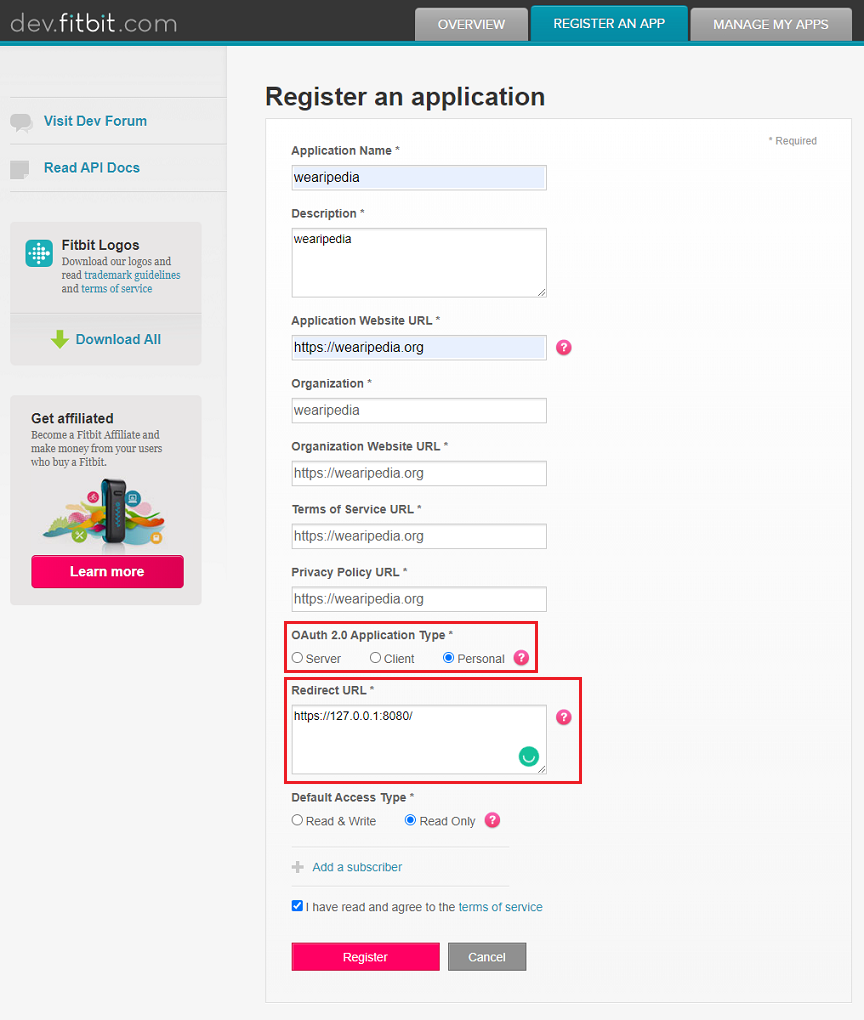

The `client_id` and `client_secret` can be accessed under **Manage My Apps** as shown below.



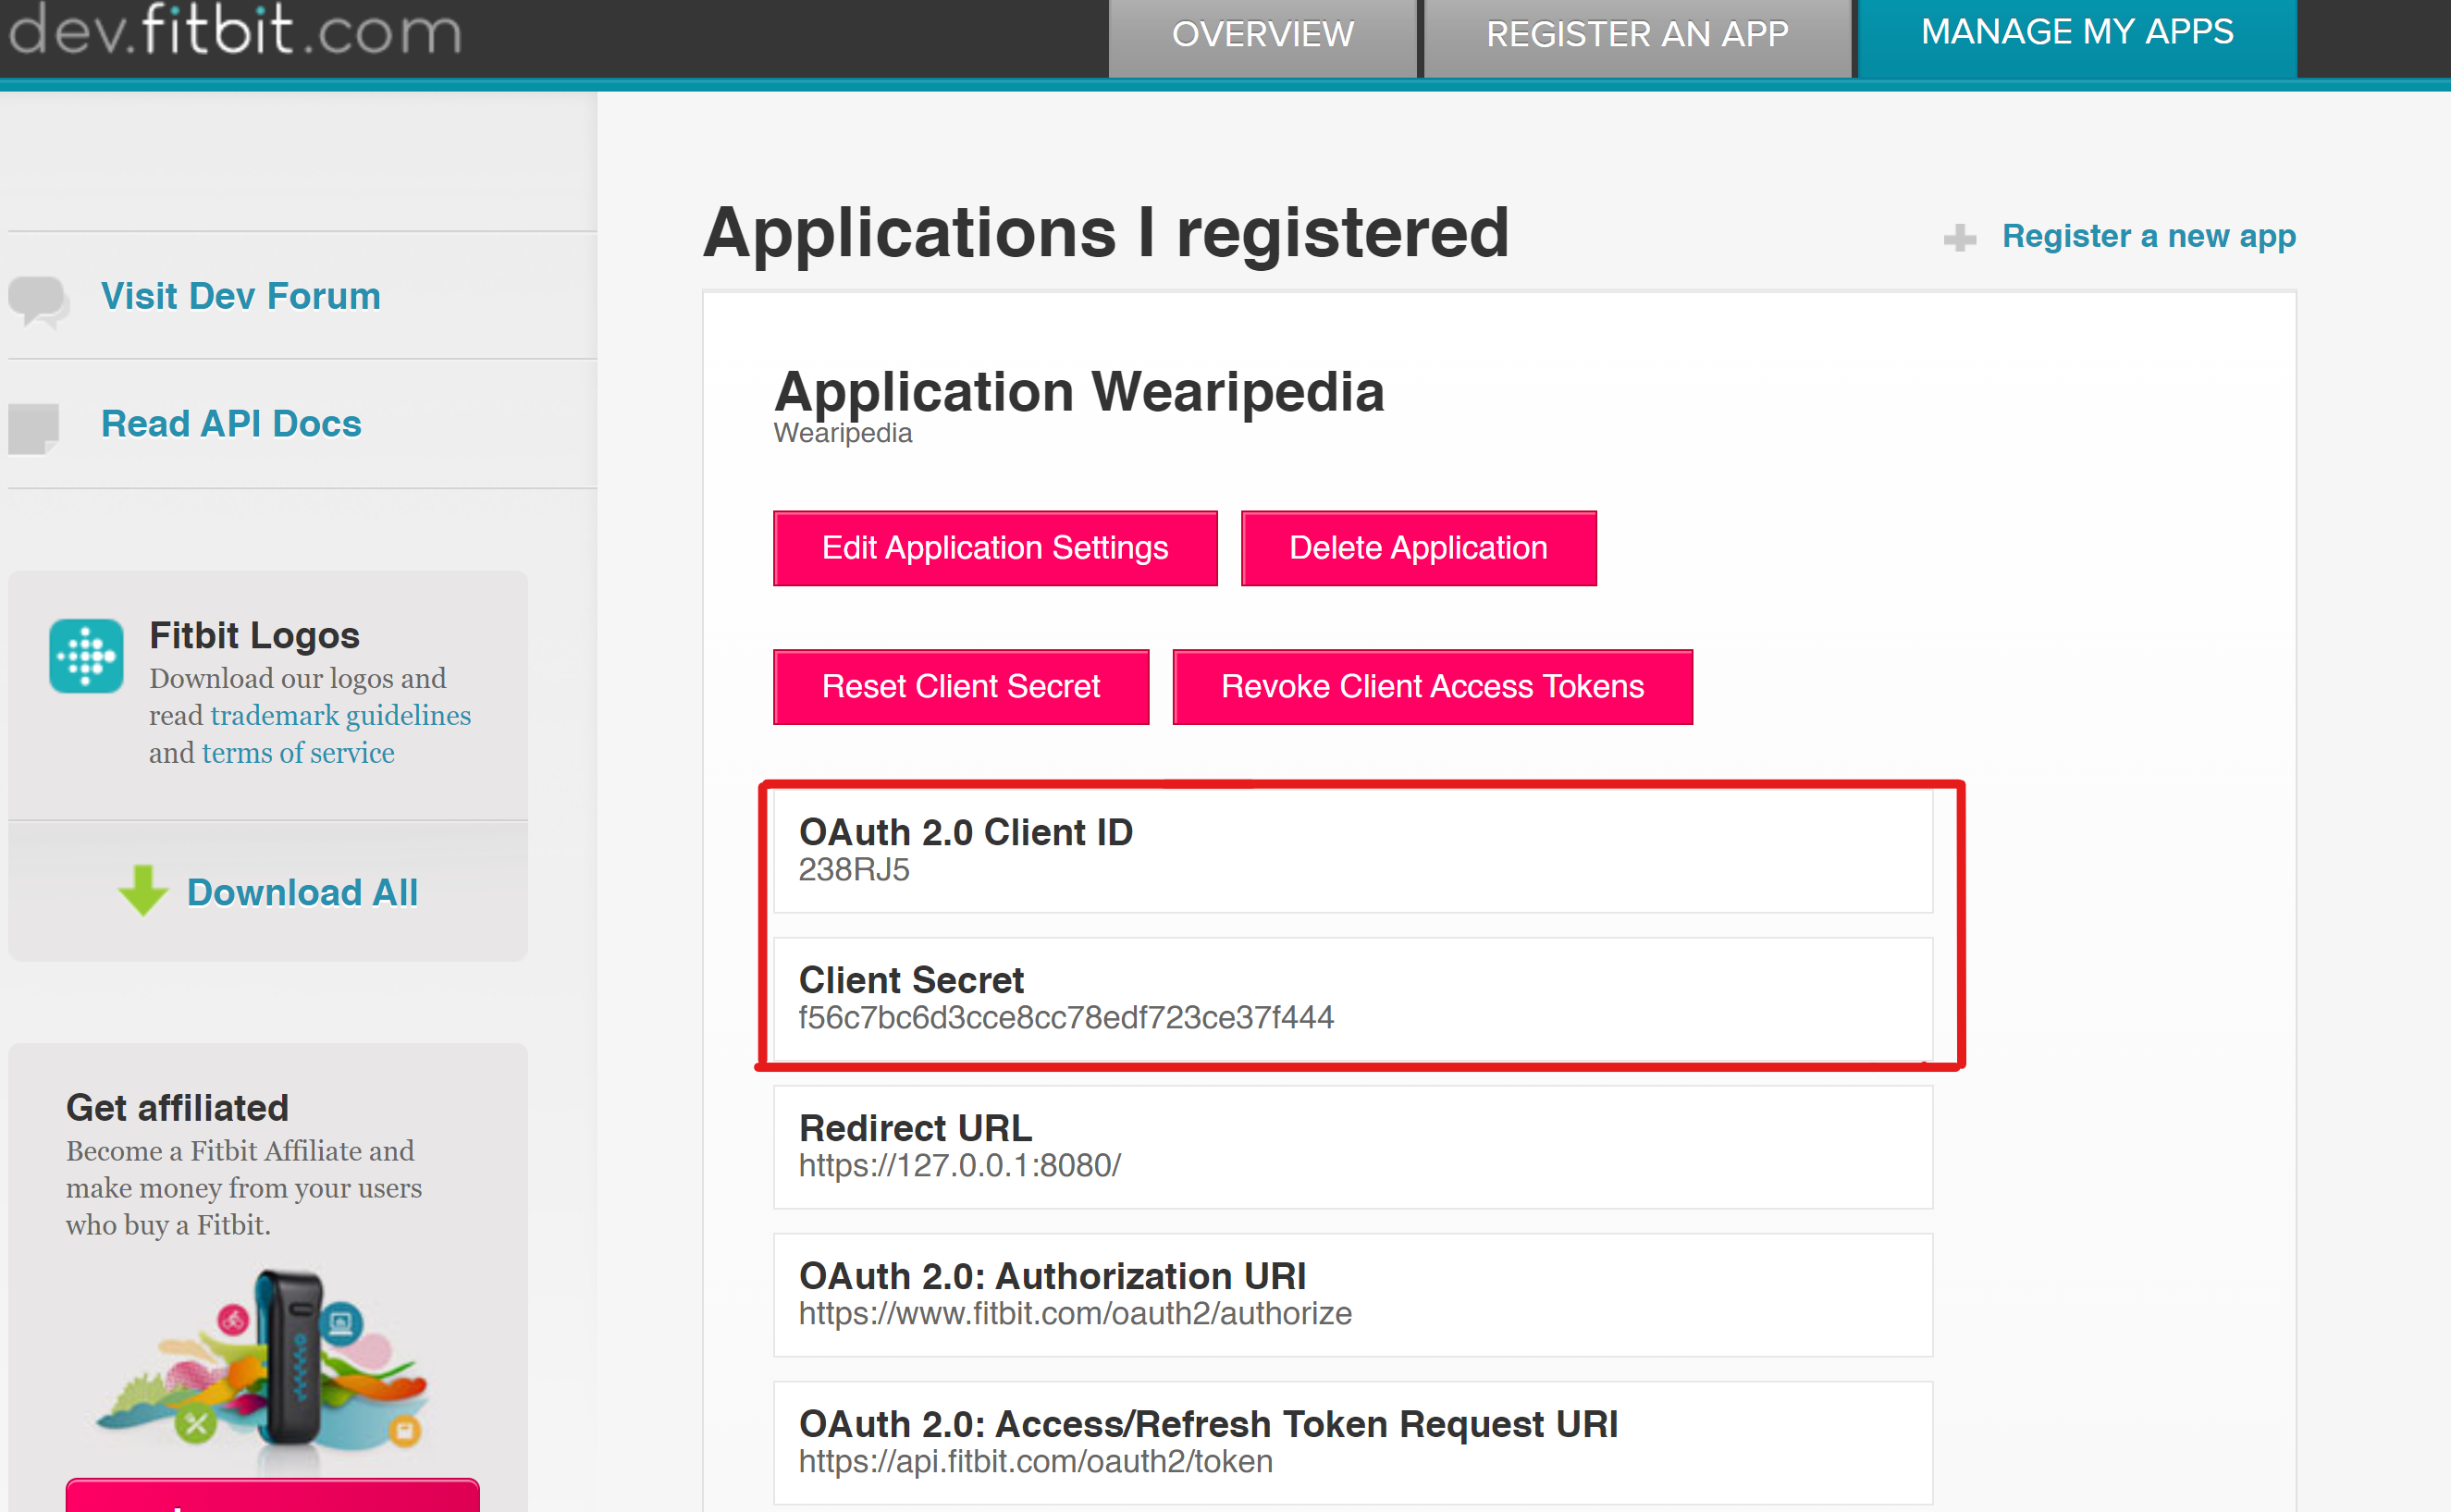



Afterwards, we initialize a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) to hold all variables relevant to authenticating, authorizing, and calling the API later.

In [165]:
#@title Insert client_id and client_secret

client_id = "" #@param {type:"string"}
client_secret = "" #@param {type:"string"}

code_verifier = base64.urlsafe_b64encode(
    os.urandom(43)
).decode("utf-8") if "code_verifier" not in locals() else code_verifier
code_challenge = base64.urlsafe_b64encode(
    hashlib.sha256(code_verifier.encode("utf-8")).digest()
).decode("utf-8").replace('=', '')

variables = dict()

# user specified
variables["client_id"] = client_id
variables["client_secret"] = client_secret
variables["expires_in"] = "31536000"  # expiry of token in seconds

# constants or one-time generated
variables["code_verifier"] = code_verifier
variables["code_challenge"] = code_challenge
variables["code_challenge_method"] = "S256"
variables["response_type"] = "token"  # code
variables["scope"] = (
    "weight%20location%20settings%20profile%20nutrition%20" +
    "activity%20sleep%20heartrate%20social"
)
variables["prompt"] = "none"
variables["redirect_uri"] = "https://127.0.0.1:8080/"
variables["grant_type"] = "authorization_code"
variables["authorization"] = base64.urlsafe_b64encode(
    bytes(variables["client_id"] + ":" + variables["client_secret"], "utf-8")
).decode("utf-8")

## 2.2 Authorize the app


Next, we display Fitbit's authorization page by typing a specific URL on a web browser. A code challenge and code verifier is required to progress further. The concept is comprehensively outlined [here](https://tools.ietf.org/html/rfc7636).

The URL should consist of the following required parameters (split into "variable" and "non-variable" parameters).

- Variable parameters
* `client_id`: Fitbit API application ID (under manage my apps specified in 2.1, link [here](https://dev.fitbit.com/apps), requires login)
* `code_challenge`: base64url-encoded SHA256 hash of the code verifier, can be obtained [here](https://example-app.com/pkce)
* `code_challenge_method`: S256

- Non-variable parameters
* `scope`: space-delimited list of data collections requested by the application
* `response_type`: code

The resulting URL is demonstrated below.

In [166]:
# combine all parameters into the url string
url = "https://www.fitbit.com/oauth2/authorize"  # authorization endpoint
for key in ["client_id", "redirect_uri", "code_challenge", "code_challenge_method", "scope", "response_type", "expires_in"]:
    if url == "https://www.fitbit.com/oauth2/authorize":
        url += "?" + key + "=" + variables[key]
    else:
        url += "&" + key + "=" + variables[key]

print(url)

https://www.fitbit.com/oauth2/authorize?client_id=&redirect_uri=https://127.0.0.1:8080/&code_challenge=G3O95QRdHgF8mErNWdK9ZP6UwHL9HpnZsVltfjQC8PM&code_challenge_method=S256&scope=weight%20location%20settings%20profile%20nutrition%20activity%20sleep%20heartrate%20social&response_type=token&expires_in=31536000


Click the URL above to access the Authorization page. Check **Allow All** and click the **Allow** button in red as shown below

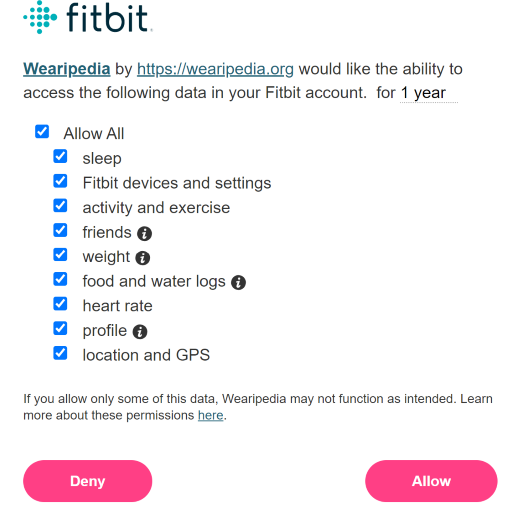

## 2.3 Retrieving The Authorization Code

If the `response_type` is `token`, an `access_token` is provided to you as part of the url.

https://127.0.0.1:8080/#access_token=*****&user_id=9FRGPT&scope=location+social+weight+heartrate+activity+profile+settings+nutrition+sleep&token_type=Bearer&expires_in=31536000

In the example above, the `access_token` is *********.

Store the `access_code` inside the `variables` dictionary

In [167]:
#@title Add your own access token
Accesstoken = "*****" #@param {type:"string"}
variables["access_token"] = Accesstoken

## 2.4 Calling the API

In [168]:
# executes a GET request on the API
def call_API(
    access_token: str,
    url: str,
    call: str = "GET"
):
    headers = {
        "Authorization": "Bearer " + access_token
    }
    return requests.request(
        call, url=url, headers=headers).json()

In [169]:
# calls user profile
call_API(
    access_token=variables["access_token"],
    url="https://api.fitbit.com/1/user/-/profile.json")

{'success': False,
 'errors': [{'errorType': 'invalid_token',
   'message': 'Access token invalid: *****. Visit https://dev.fitbit.com/docs/oauth2 for more information on the Fitbit Web API authorization process.'}]}

# 3. Data Extraction

Here we are going to use the Wearipedia API to handle the Oauth connection. A full list of data types and endpoints are available [here](https://dev.fitbit.com/build/reference/web-api/explore/).

In brief, the categories are:
* [Activity](https://dev.fitbit.com/build/reference/web-api/activity/)
* [Activity Intraday Time Series](https://dev.fitbit.com/build/reference/web-api/activity/#get-activity-intraday-time-series)
* [Activity Time Series](https://dev.fitbit.com/build/reference/web-api/activity/#get-activity-intraday-time-series)
* [Body and Weight](https://dev.fitbit.com/build/reference/web-api/body/)
* [Body and Weight Time Series](https://dev.fitbit.com/build/reference/web-api/body/#body-time-series)
* [Devices](https://dev.fitbit.com/build/reference/web-api/devices/)
* [Food and Water](https://dev.fitbit.com/build/reference/web-api/nutrition/)
* [Food and Water Time Series](https://dev.fitbit.com/build/reference/web-api/nutrition/)
* [Friends](https://dev.fitbit.com/build/reference/web-api/friends/)
* [Heart Rate Intraday Time Series](https://dev.fitbit.com/build/reference/web-api/heartrate-timeseries/)
* [Heart Rate Time Series](https://dev.fitbit.com/build/reference/web-api/heartrate-timeseries/)
* [Sleep](https://dev.fitbit.com/build/reference/web-api/sleep/)
* [Subscriptions](https://dev.fitbit.com/build/reference/web-api/subscription/)
* [User](https://dev.fitbit.com/build/reference/web-api/user/)


In [170]:
#@title Set up the start and end dates (YYYY-MM-DD) or a single date for day's data extraction
START_DATE = "2022-07-01" #@param {type:"string"}
END_DATE = "2022-08-30" #@param {type:"string"}
single_date = "2022-12-11" #@param {type:"string"}
ACCESS_TOKEN = variables["access_token"]
synthetic = True #@param {type:"boolean"}


device = wearipedia.get_device("fitbit/fitbit_sense")  # Initialize the device object for the firbit charge 4

if not synthetic:
  # If the data is not synthetic, authenticate using the access token
  device.authenticate(ACCESS_TOKEN)

# Parameters for retrieving data from the device
params = {"seed": 100, "start_date": START_DATE, "end_date": END_DATE, "single_date": single_date}


# Retrieve data for the data categories
sleep = device.get_data("sleep", params)
steps = device.get_data("steps", params)
minutesVeryActive = device.get_data("minutesVeryActive", params)
minutesFairlyActive = device.get_data("minutesFairlyActive", params)
minutesLightlyActive = device.get_data("minutesLightlyActive", params)
distance = device.get_data("distance", params)
minutesSedentary = device.get_data("minutesSedentary", params)
heart_rate_day = device.get_data("heart_rate_day", params)
hrv = device.get_data("hrv", params)
distance_day = device.get_data("distance_day", params)

# Store the retrieved data in a dictionary
api_data = {}
api_data['sleep'] = sleep
api_data['steps'] = steps
api_data['minutesVeryActive'] = minutesVeryActive
api_data['minutesFairlyActive'] = minutesFairlyActive
api_data['minutesLightlyActive'] = minutesLightlyActive
api_data['distance'] = distance
api_data['minutesSedentary'] = minutesSedentary
api_data['heart_rate_day'] = heart_rate_day
api_data['hrv'] = hrv
api_data['distance_day'] = distance_day


In [171]:
api_data

{'sleep': [{'sleep': [{'dateOfSleep': '2022-07-01',
     'duration': 33608000,
     'efficiency': 94,
     'endTime': '2022-07-02T08:01:04',
     'infoCode': 0,
     'isMainSleep': True,
     'logId': 449619419,
     'logType': 'auto_detected',
     'minutesAfterWakeup': 7,
     'minutesAsleep': 512,
     'minutesAwake': 34,
     'minutesToFallAsleep': 8,
     'startTime': '2022-07-01T22:40:56',
     'timeInBed': 560,
     'levels': {'data': [{'dateTime': '2022-07-01T22:40:56',
        'level': 'wake',
        'seconds': 480},
       {'dateTime': '2022-07-01T23:08:30', 'level': 'wake', 'seconds': 420},
       {'dateTime': '2022-07-01T23:08:30', 'level': 'deep', 'seconds': 1792},
       {'dateTime': '2022-07-01T23:38:22', 'level': 'light', 'seconds': 1768},
       {'dateTime': '2022-07-02T00:37:42', 'level': 'rem', 'seconds': 736},
       {'dateTime': '2022-07-02T01:19:26', 'level': 'rem', 'seconds': 1186},
       {'dateTime': '2022-07-02T01:51:28', 'level': 'rem', 'seconds': 1626},
   

# 4. Data Exporting

## Exporting to JSON (R, Matlab, etc.), CSV, and Excell.

In this section, we export all of this data to JSON, which  with popular scientific computing software (R, Matlab).
Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [172]:
import json


#@title Select which format to export data!
# set which format you prefer to export
use_JSON = True #@param {type:"boolean"}
use_CSV = True #@param {type:"boolean"}
use_Excel = True #@param {type:"boolean"}

if use_JSON:

  json.dump(api_data["sleep"], open("sleep.json", "w"))
  json.dump(api_data["steps"], open("steps.json", "w"))
  json.dump(api_data["minutesVeryActive"], open("minutesVeryActive.json", "w"))
  json.dump(api_data["minutesFairlyActive"], open("minutesFairlyActive.json", "w"))
  json.dump(api_data["minutesLightlyActive"], open("minutesLightlyActive.json", "w"))
  json.dump(api_data["distance"], open("distance.json", "w"))
  json.dump(api_data["minutesSedentary"], open("minutesSedentary.json", "w"))
  json.dump(api_data["heart_rate_day"], open("heart_rate_day.json", "w"))
  json.dump(api_data["hrv"], open("hrv.json", "w"))
  json.dump(api_data["distance_day"], open("distance_day.json", "w"))

  complete = {
      "sleep": api_data["sleep"],
      "steps": api_data["steps"],
      "minutesVeryActive": api_data["minutesVeryActive"],
      "minutesFairlyActive": api_data["minutesFairlyActive"],
      "minutesLightlyActive": api_data["minutesLightlyActive"],
      "distance": api_data["distance"],
      "minutesSedentary": api_data["minutesSedentary"],
      "heart_rate_day": api_data["heart_rate_day"],
      "hrv": api_data["hrv"],
      "distance_day": api_data["distance_day"],
  }

  json.dump(complete, open("complete.json", "w"))

if use_CSV:
  pd.DataFrame(api_data["sleep"]).to_csv("sleep.csv", index=False)
  pd.DataFrame(api_data["steps"]).to_csv("steps.csv", index=False)
  pd.DataFrame(api_data["minutesVeryActive"]).to_csv("minutesVeryActive.csv", index=False)
  pd.DataFrame(api_data["minutesFairlyActive"]).to_csv("minutesFairlyActive.csv", index=False)
  pd.DataFrame(api_data["minutesLightlyActive"]).to_csv("minutesLightlyActive.csv", index=False)
  pd.DataFrame(api_data["distance"]).to_csv("distance.csv", index=False)
  pd.DataFrame(api_data["minutesSedentary"]).to_csv("minutesSedentary.csv", index=False)
  pd.DataFrame(api_data["heart_rate_day"]).to_csv("heart_rate_day.csv", index=False)
  pd.DataFrame(api_data["hrv"]).to_csv("hrv.csv", index=False)
  pd.DataFrame(api_data["distance_day"]).to_csv("distance_day.csv", index=False)

if use_Excel:
  pd.DataFrame(api_data["sleep"]).to_excel("sleep.xlsx", index=False)
  pd.DataFrame(api_data["steps"]).to_excel("steps.xlsx", index=False)
  pd.DataFrame(api_data["minutesVeryActive"]).to_excel("minutesVeryActive.xlsx", index=False)
  pd.DataFrame(api_data["minutesFairlyActive"]).to_excel("minutesFairlyActive.xlsx", index=False)
  pd.DataFrame(api_data["minutesLightlyActive"]).to_excel("minutesLightlyActive.xlsx", index=False)
  pd.DataFrame(api_data["distance"]).to_excel("distance.xlsx", index=False)
  pd.DataFrame(api_data["minutesSedentary"]).to_csv("minutesSedentary.csv", index=False)
  pd.DataFrame(api_data["heart_rate_day"]).to_csv("heart_rate_day.csv", index=False)
  pd.DataFrame(api_data["hrv"]).to_csv("hrv.csv", index=False)
  pd.DataFrame(api_data["distance_day"]).to_csv("distance_day.csv", index=False)



# 5. Adherence





In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level). We will first delete chunks of data, given user input, and then visualize user non-adherence.

In [173]:
#@title 5.1 Non-adherence simulation and detection
import random as random

# First prep the data for removing data points
api_data['sleep'] = api_data['sleep'][0]["sleep"]
api_data['steps'] = api_data['steps'][0]["activities-steps"]
api_data['minutesVeryActive'] = api_data['minutesVeryActive'][0]["activities-minutesVeryActive"]
api_data['minutesFairlyActive'] = api_data['minutesFairlyActive'][0]["activities-minutesFairlyActive"]
api_data['minutesLightlyActive'] = api_data['minutesLightlyActive'][0]["activities-minutesLightlyActive"]
api_data['distance'] = api_data['distance'][0]["activities-distance"]
api_data['minutesSedentary'] = api_data['minutesSedentary'][0]["activities-minutesSedentary"]



block_level = "day" #@param ["day", "week"]
steps_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}
sleep_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}
minutesVeryActive_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}
minutesFairlyActive_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}
distance_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}
minutesLightlyActive_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}
minutesSedentary_nonadherence_percent = 0 #@param {type:"slider", min:0, max:1, step:0.01}

detect_adherence_only = True #@param {type:"boolean"}


def remove_entries(data, percent):
    """
    Removes a percentage of entries from a list of lists.

    :param data: list of lists representing the entries to be processed
    :param percent: float representing the percentage of entries to be removed
    :return: list of lists representing the remaining entries after removal
    """
    num_entries = len(data)
    num_entries_to_keep = int(percent * num_entries)
    idxes_to_keep = np.random.choice(np.arange(num_entries), replace=False, size=num_entries_to_keep)
    return [data[i] for i in idxes_to_keep]

sleep_adherence = remove_entries(api_data['sleep'], sleep_nonadherence_percent)
steps_adherence = remove_entries(api_data['steps'], steps_nonadherence_percent)
minutesVeryActive_adherence = remove_entries(api_data['minutesVeryActive'], minutesVeryActive_nonadherence_percent)
distance_adherence = remove_entries(api_data['distance'], distance_nonadherence_percent)
minutesFairlyActive_adherence = remove_entries(api_data['minutesFairlyActive'], minutesFairlyActive_nonadherence_percent)
minutesLightlyActive_adherence = remove_entries(api_data['minutesLightlyActive'], minutesLightlyActive_nonadherence_percent)
minutesSedentary_adherence = remove_entries(api_data['minutesSedentary'], minutesSedentary_nonadherence_percent)

if not detect_adherence_only:
    if block_level == "day":
        block_length = 1
    elif block_level == "week":
        block_length = 7

    sleep_num_blocks_to_keep = int((1 - sleep_nonadherence_percent) * len(api_data['sleep']))
    steps_num_blocks_to_keep = int((1 - steps_nonadherence_percent) * len(api_data['sleep']))
    minutesVeryActive_num_blocks_to_keep = int((1 - minutesVeryActive_nonadherence_percent) * len(api_data['sleep']))
    minutesFairlyActive_num_blocks_to_keep = int((1 - minutesFairlyActive_nonadherence_percent) * len(api_data['sleep']))
    distance_num_blocks_to_keep = int((1 - distance_nonadherence_percent) * len(api_data['sleep']))
    minutesLightlyActive_num_blocks_to_keep = int((1 - minutesLightlyActive_nonadherence_percent) * len(api_data['sleep']))
    minutesSedentary_num_blocks_to_keep = int((1 - minutesSedentary_nonadherence_percent) * len(api_data['sleep']))

    minutesVeryActive_idxes = np.random.choice(np.arange(len(api_data['minutesVeryActive'])), replace=False, size=minutesVeryActive_num_blocks_to_keep)
    minutesVeryActive_adherence = [api_data['minutesVeryActive'][i] for i in minutesVeryActive_idxes]
    api_data['minutesVeryActive'] = minutesVeryActive_adherence

    sleep_idxes = np.random.choice(np.arange(len(api_data['sleep'])), replace=False, size=sleep_num_blocks_to_keep)
    sleep_adherence = [api_data['sleep'][i] for i in sleep_idxes]
    api_data['sleep'] = sleep_adherence

    steps_idxes = np.random.choice(np.arange(len(api_data['steps'])), replace=False, size=steps_num_blocks_to_keep)
    steps_adherence = [api_data['steps'][i] for i in steps_idxes]
    api_data['steps'] = steps_adherence

    minutesFairlyActive_idxes = np.random.choice(np.arange(len(api_data['minutesFairlyActive'])), replace=False, size=minutesFairlyActive_num_blocks_to_keep)
    minutesFairlyActive_adherence = [api_data['minutesFairlyActive'][i] for i in minutesFairlyActive_idxes]
    api_data['minutesFairlyActive'] = minutesFairlyActive_adherence

    distance_idxes = np.random.choice(np.arange(len(api_data['distance'])), replace=False, size=distance_num_blocks_to_keep)
    distance_adherence = [api_data['distance'][i] for i in distance_idxes]
    api_data['distance'] = distance_adherence

    minutesLightlyActive_idxes = np.random.choice(np.arange(len(api_data['minutesLightlyActive'])), replace=False, size=minutesLightlyActive_num_blocks_to_keep)
    minutesLightlyActive_adherence = [api_data['minutesLightlyActive'][i] for i in minutesLightlyActive_idxes]
    api_data['minutesLightlyActive'] = minutesLightlyActive_adherence

    minutesSedentary_idxes = np.random.choice(np.arange(len(api_data['minutesSedentary'])), replace=False, size=minutesSedentary_num_blocks_to_keep)
    minutesSedentary_adherence = [api_data['minutesSedentary'][i] for i in minutesSedentary_idxes]
    api_data['minutesSedentary'] = minutesSedentary_adherence

# After the alteration of the data, lets return it to the original form
api_data['sleep'] = [ {"sleep": api_data['sleep']} ]
api_data['steps'] = [ {"activities-steps": api_data['steps']} ]
api_data['minutesVeryActive'] = [ {"activities-minutesVeryActive": api_data['minutesVeryActive']} ]
api_data['minutesFairlyActive'] = [ {"activities-minutesFairlyActive": api_data['minutesFairlyActive']} ]
api_data['minutesLightlyActive'] = [ {"activities-minutesLightlyActive": api_data['minutesLightlyActive']} ]
api_data['distance'] = [ {"activities-distance": api_data['distance']} ]
api_data['minutesSedentary'] = [ {"activities-minutesSedentary": api_data['minutesSedentary']} ]

### 5.2 Non-adherence visualization


Here we are going to look into what days data wasn't collected. Since the days in which data wasn't collected show "zero" values for the data, then filter this out to increase the accuracy of the analysis. This is because zero values will be consided data points in the analysis which will alter the results.

So we will create a function that can come later in aid to delete the data which have no value, but first lets take a look at our sample of data.

<ipython-input-174-611c9d076d98>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Date", y="steps", data=df, palette = 'Dark2_r' )


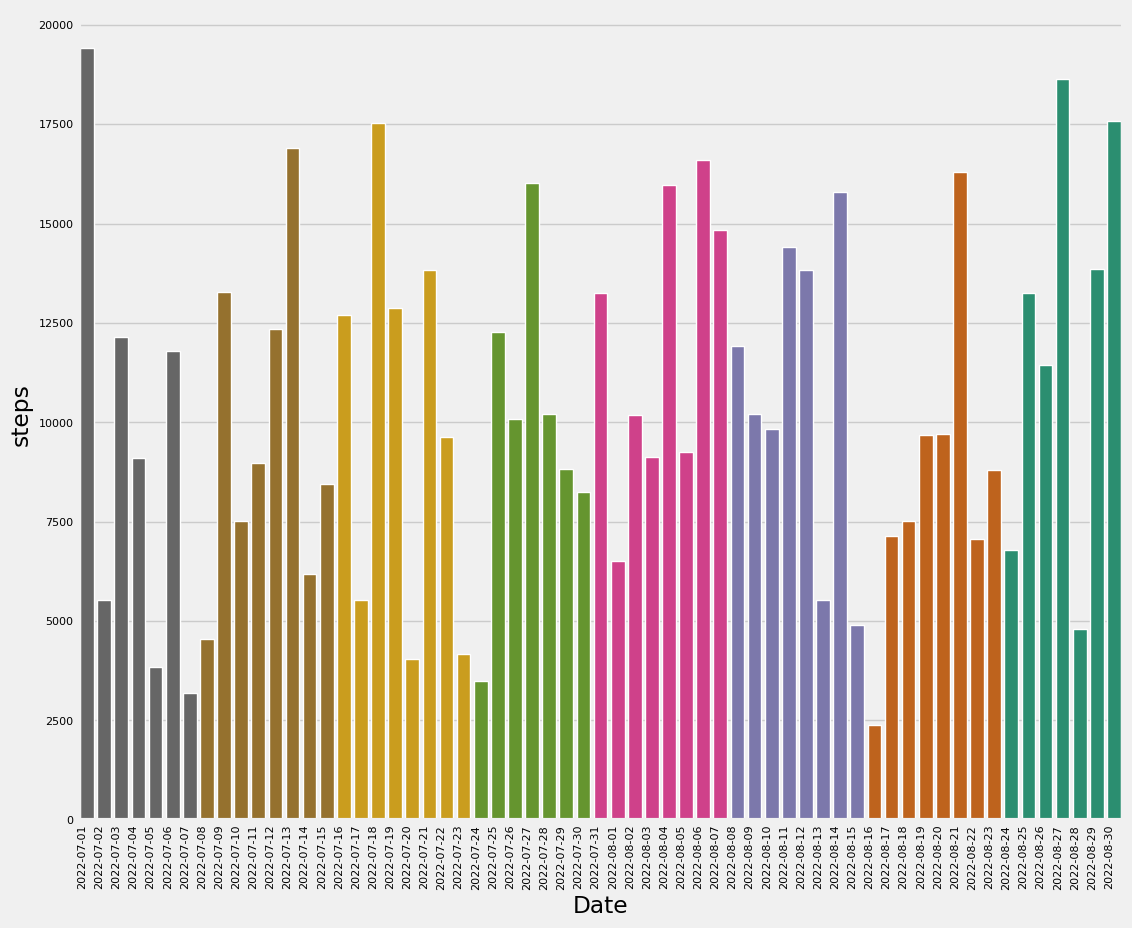

In [174]:
# First we are going to aggregate the data in arrays. We are taking steps as an example here
dates = []
steps = []

for datapoint in api_data['steps'][0]['activities-steps']:
    dates.append(datapoint['dateTime'])
    steps.append(float(datapoint['value']))

#Using a pandas dataframe to aggregate the data
d = {'Date': dates, 'steps': steps}
df = pd.DataFrame(data=d)

with plt.style.context('fivethirtyeight'):
    #Creating the plot
    #Resizing the plot
    fig,ax = plt.subplots()
    fig.set_size_inches(12,10)

    sns.set_theme(style="dark")
    ax = sns.barplot(x="Date", y="steps", data=df, palette = 'Dark2_r' )

    # adjust tick sizes
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)

    # rotates and right-aligns the x labels so they don't crowd each other.
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=90, horizontalalignment='right')
    plt.show()


As shown above, alot of the data is not recorded, and that's what we don't want to include in the analysis so lets filter this out.

In [175]:
#since the data will consist of multiple arrays carrying multiple data points,
# we will create the function such that it gets the list of arrays as a parameter
# and the refrence index for the array to examine the data from

def remove_non_wear(lst, refrence_index):
  newlst = []
  for i in range(len(lst)):
    newlst.append([])

  for index in range(len(lst[refrence_index])):
    if lst[refrence_index][index] != 0:
      for array in lst:
        newlst[lst.index(array)].append(array[index])
  return newlst

<ipython-input-176-af50bc322fc0>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Date", y="steps", data=df, palette = 'Dark2_r' )


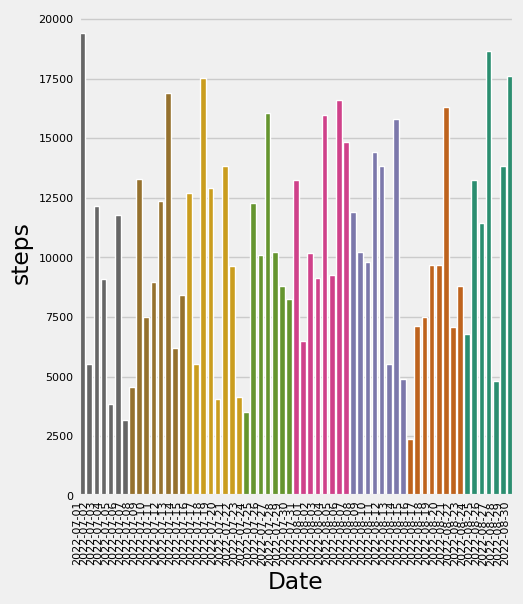

In [176]:
# Lets put that to test

#Now let's test this
new_arrays = remove_non_wear([dates, steps], 1)

#creating a new plot with the new data
dates = new_arrays[0]
steps = new_arrays[1]

#creating a new plot with the new data
d = {'Date': dates, 'steps': steps}
df = pd.DataFrame(data=d)

with plt.style.context('fivethirtyeight'):
    #Resizing the plot
    fig,ax = plt.subplots()
    fig.set_size_inches(5,6)

    sns.set_theme(style="dark")
    ax = sns.barplot(x="Date", y="steps", data=df, palette = 'Dark2_r' )

    # adjust tick sizes
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)

    # rotates and right-aligns the x labels so they don't crowd each other.
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=90, horizontalalignment='right')
    plt.show()


Initially, you might think that the data on 22-07-25 wasn't filtered out but lets check if it has a non-zero value

In [177]:
print(steps)

[19410.0, 5530.0, 12145.0, 9095.0, 3840.0, 11790.0, 3180.0, 4555.0, 13280.0, 7510.0, 8970.0, 12350.0, 16900.0, 6180.0, 8440.0, 12710.0, 5525.0, 17540.0, 12890.0, 4045.0, 13845.0, 9625.0, 4160.0, 3495.0, 12280.0, 10090.0, 16035.0, 10210.0, 8815.0, 8240.0, 13255.0, 6500.0, 10180.0, 9120.0, 15980.0, 9265.0, 16605.0, 14840.0, 11920.0, 10215.0, 9825.0, 14410.0, 13845.0, 5540.0, 15790.0, 4905.0, 2375.0, 7135.0, 7515.0, 9690.0, 9700.0, 16305.0, 7075.0, 8795.0, 6780.0, 13255.0, 11445.0, 18645.0, 4800.0, 13850.0, 17595.0]


The number of steps is only 11 which indicates that the fitbit was taken off most of the day. It is considered an outlier value for this reason and we will filter this out in section 5.1.

Now that we know this filteration works, lets recreate some visuals from the app

# 6. Visualization

We've extracted lots of data, but what does it look like?

In this section, we will be visualizing our three kinds of data in a simple, customizable plot! This plot is intended to provide a starter example for plotting, whereas later examples emphasize deep control and aesthetics.

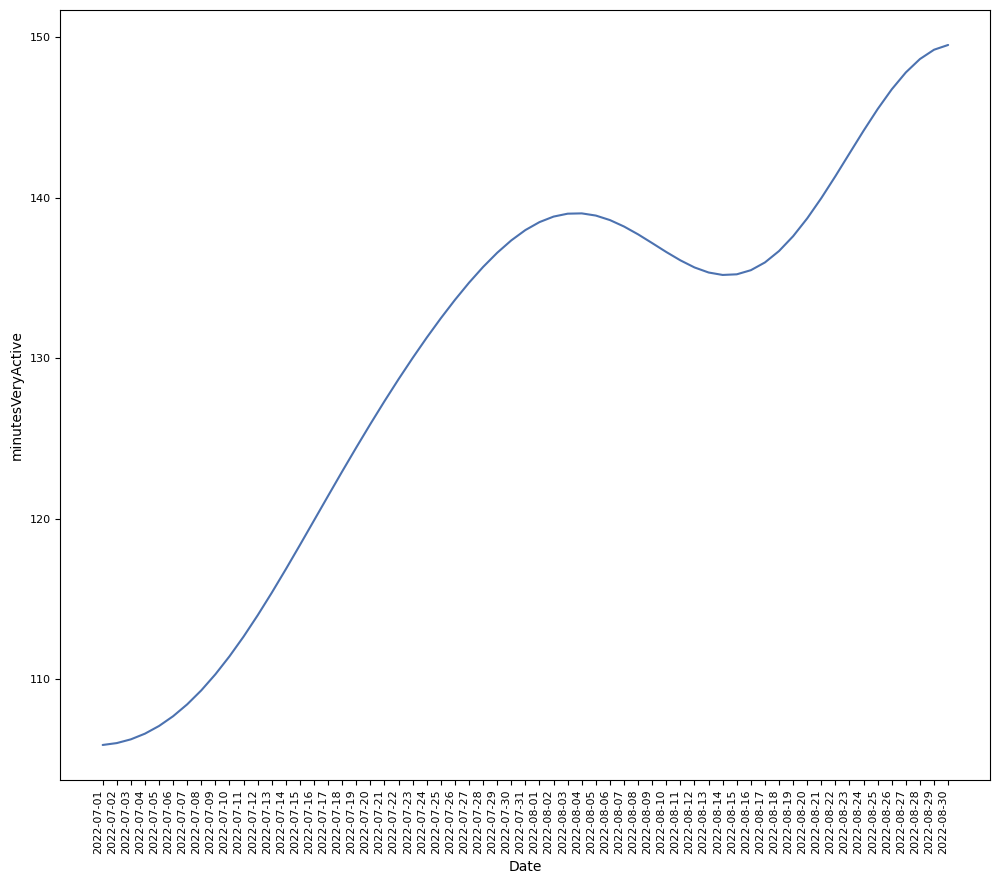

In [178]:
feature = "minutesVeryActive" #@param ["minutesVeryActive", "distance", "steps"]
smoothness = 0.9 #@param {type:"slider", min:0, max:1, step:0.01}
sigma = 10 * smoothness

if feature == "steps":
  steps = []
  dates = []
  for datapoint in api_data['steps'][0]['activities-steps']:
      dates.append(str(datapoint['dateTime']))
      steps.append(float(datapoint['value']))

  steps = list(gaussian_filter(steps, sigma=sigma))

  d = {'Date': dates, 'steps': steps}
  df = pd.DataFrame(data=d)

  with plt.style.context('tableau-colorblind10'):
      #Creating the plot
      #Resizing the plot
      fig,ax = plt.subplots()
      fig.set_size_inches(12,10)

      sns.set_theme(style="dark")
      ax = sns.lineplot(x="Date", y="steps", data=df, color = 'g'  )

      # adjust tick sizes
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      # rotates and right-aligns the x labels so they don't crowd each other.
      for label in ax.get_xticklabels(which='major'):
          label.set(rotation=90, horizontalalignment='right')

      plt.show()

elif feature == "distance":

  distance = []
  dates = []
  for datapoint in api_data['distance'][0]['activities-distance']:
      dates.append(str(datapoint['dateTime']))
      distance.append(float(datapoint['value']))

  distance = list(gaussian_filter(distance, sigma=sigma))

  d = {'Date': dates, 'distance': distance}
  df = pd.DataFrame(data=d)

  with plt.style.context('tableau-colorblind10'):
      #Creating the plot
      #Resizing the plot
      fig,ax = plt.subplots()
      fig.set_size_inches(12,10)

      sns.set_theme(style="dark")
      ax = sns.lineplot(x="Date", y="distance", data=df, color = 'r'  )

      # adjust tick sizes
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      # rotates and right-aligns the x labels so they don't crowd each other.
      for label in ax.get_xticklabels(which='major'):
          label.set(rotation=90, horizontalalignment='right')

      plt.show()

elif feature == "minutesVeryActive":

  minutesVeryActive = []
  dates = []
  for datapoint in api_data['minutesVeryActive'][0]['activities-minutesVeryActive']:
      dates.append(str(datapoint['dateTime']))
      minutesVeryActive.append(float(datapoint['value']))

  minutesVeryActive = list(gaussian_filter(minutesVeryActive, sigma=sigma))

  d = {'Date': dates, 'minutesVeryActive': minutesVeryActive}
  df = pd.DataFrame(data=d)

  with plt.style.context('tableau-colorblind10'):
      #Creating the plot
      #Resizing the plot
      fig,ax = plt.subplots()
      fig.set_size_inches(12,10)

      sns.set_theme(style="dark")
      ax = sns.lineplot(x="Date", y="minutesVeryActive", data=df, color = 'b'  )

      # adjust tick sizes
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      # rotates and right-aligns the x labels so they don't crowd each other.
      for label in ax.get_xticklabels(which='major'):
          label.set(rotation=90, horizontalalignment='right')

      plt.show()



# 7. Advanced Visualization

## 7.1 Visualizing Heart Rate

Here, we are going to replicate the following visual from the fitbit app that presents the heart rate in a single day.

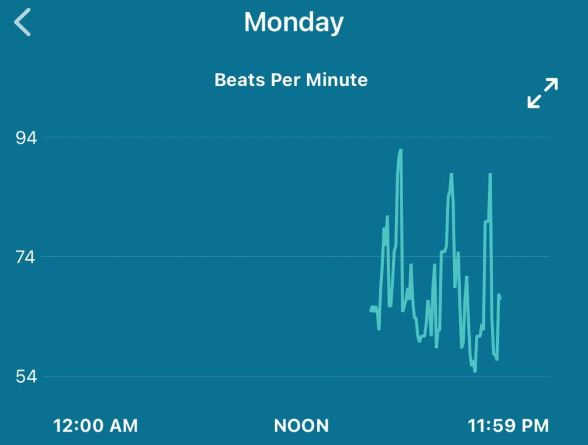

First we are going to collect the data in arrays then create the plot and make it look like the original plot. At the end, we place the labels and adjust the font sizes.

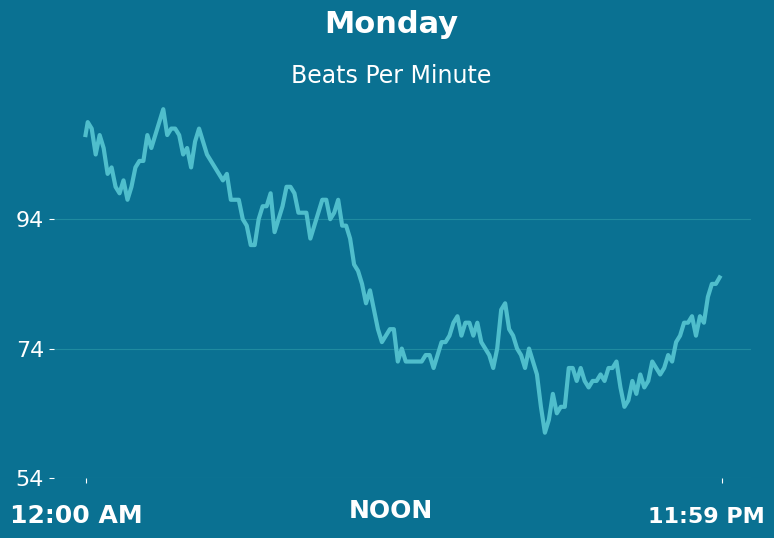

In [179]:
# First we are going to aggregate the data in arrays. We are taking steps as an example here
time = []
heart_rate = []

for datapoint in api_data['heart_rate_day'][0]['activities-heart-intraday']['dataset']:
    time.append(int(datapoint['time'][0:2]) * 60 + int(datapoint['time'][3:5]))
    heart_rate.append(float(datapoint['value']))

# Lets smooth out the data the way I think fitbit does something similar to
new_heart_rate = []
new_time = []
temp_time = []
counter = 0
for i in range(len(time)):
    temp_time.append(time[i])
    if counter % 9 == 0 or i == len(time)-1:
       new_heart_rate.append(heart_rate[i])
       new_time.append(sum(temp_time) / len(temp_time))
       temp_time = []
    counter+=1


with plt.style.context('dark_background'):

      # creating the plot and setting the background color
      fig = plt.figure(figsize=(9, 5))
      fig.patch.set_facecolor('#0a7192')
      # adjust the facecolor
      plt.gca().set_facecolor('#0a7192')

      plt.plot(new_time, new_heart_rate, linewidth=3, color='#4fbecc')


      # setting the width of the X axis
      times = [0, 24*60]
      plt.xticks(ticks=times, labels=['', ''])

      #keeping on only some of the y values by adjusting the labels
      bpms = [54, 74, 94]
      plt.yticks(ticks=bpms, labels=['54', '74', '94'])

      # removing the borders from four sides
      plt.gca().spines['left'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)

      # adjusting the label size
      plt.tick_params(axis='y', labelsize=16)

      # set the colors of the grid
      plt.gca().grid(axis='y', color='#1f8ba0')


      #adding labels
      plt.figtext(0.5,1.0, 'Monday', fontsize=22, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.5,0.90, 'Beats Per Minute', fontsize=17, ha='center', color ='w')
      plt.figtext(0.5,0.03, 'NOON', fontsize=18, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.15,0.02, '12:00 AM', fontsize=18, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.85,0.02, '11:59 PM', fontsize=16, ha='center', color ='w', fontweight = 'bold')





Now it looks very similar to the original plot!

## 7.2 Visualizing Distance


Now lets replicate this next visual which plots the distance walked in a certain day.

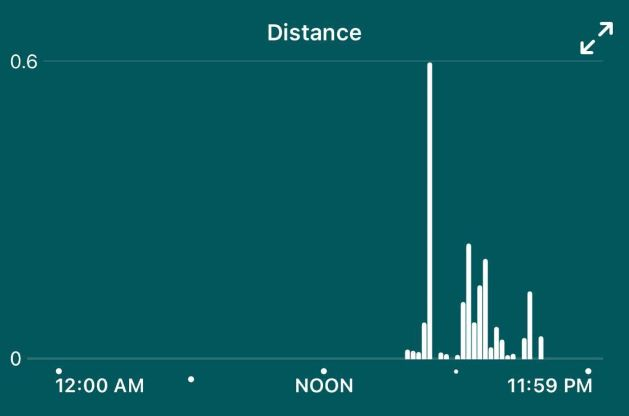

To build this plot, we are going to collect the data in arrays, plot them with matplotlib, and edit the aesthetics to look similar to the original. One interesting thing that fitbit does is that it divides the day into sections and adds the data in those sections then visualizes them. That's what we are going to do despite that it may produce different aggregates numbers.

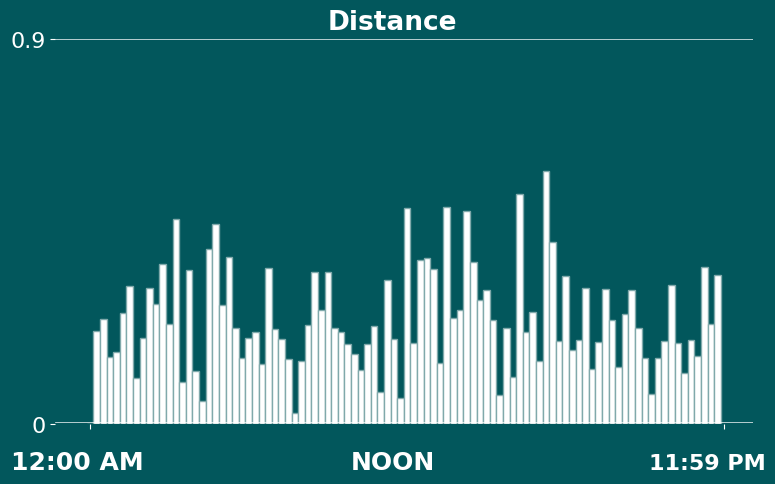

In [180]:
# First we are going to aggregate the data in arrays with only 96 entries
# Since we have 1440 datapoint, each of the 96 entries will the sum of 15 of those

time = []
distances = [0]*96

counter = 0
entry = 0
for datapoint in api_data['distance_day'][0]['activities-distance-intraday']['dataset']:
    if entry == 96:
      break
    distances[entry] += float(datapoint['value'])
    if counter % 15 == 0:
        time.append(int(datapoint['time'][0:2]) * 60 + int(datapoint['time'][3:5]))
        entry += 1
    counter += 1



with plt.style.context('dark_background'):

      # creating the plot and setting the background color
      fig = plt.figure(figsize=(9, 5))
      fig.patch.set_facecolor('#02575c')
      # adjust the facecolor
      plt.gca().set_facecolor('#02575c')

      plt.bar(time, distances, color = 'w', edgecolor = '#80a9ab', width = 15)

      # removing the borders from four sides
      plt.gca().spines['left'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)

      #keeping on only some of the y values by adjusting the labels
      bpms = [0, 0.9]
      plt.yticks(ticks=bpms, labels=['0', '0.9'])

      # Creating a horizontal lines at 0 and 0.9
      plt.axhline(y=0.005, linewidth = 0.5) # can't make one at zero so using a small number
      plt.axhline(y=0.9, linewidth = 0.5)

      # removing x labels
      times = [0, 24*60]
      plt.xticks(ticks=times, labels=['', ''])

      # adjusting the label size
      plt.tick_params(axis='y', labelsize=16)

      #adding labels
      plt.figtext(0.5,0.90, 'Distance', fontsize=19, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.5,0.02, 'NOON', fontsize=18, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.15,0.02, '12:00 AM', fontsize=18, ha='center', color ='w', fontweight = 'bold')
      plt.figtext(0.85,0.02, '11:59 PM', fontsize=16, ha='center', color ='w', fontweight = 'bold')



Although the numbers are the same because we don't know how many parts are in the orginal graph, the pattern looks close enough.

# 8. Outlier Detection and data Cleaning



Detecting outliers is a uselful thing to do before an analysis which is evident from the datapoint shown in section 4.1 where the device was worn for a very little time. Data points like this may affect the results of a data analysis done on the data that contain them. There are multiple ways of annotating outliers and here we are going to present two of them.  

We find outliers and remove them in order to get better analysis accuracy by removing the possibility of measurement errors, but at the same time it can affect the result's accuracy since some outliers are true outliers: outliers that is important in the data itelf. Check [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7485938) out to learn more about the effects of removing outliers.

### 8.1 First Way to Detect Outliers: Iterquartile range

According to the [National Institute of Standards and Technology's handbook](https://https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm#:~:text=An%20outlier%20is%20an%20observation,what%20will%20be%20considered%20abnormal.), we assume that a "mild outlier" is a datapoint that is higher than or lower than the first quartile or higher than the third quartile by a distance of the interquartile range multiplied by 1.5 points, while "extreme outliers" are ones that distance multipled by 3 points instead. Lets create a function that applies this on a given array.

Quartiles are the values that divide a list of numbers into quarters and the "Interquartile Range" is from Q1 to Q3. We check if point >= Q3+(1.5* interquartile_Range) or point <= q1 - (1.5*interquartile_Range)


In [181]:
def interquartile(array):
    #find interquartile range
    quartiles = np.quantile(array, [0.25,0.75])
    q1, q3 = quartiles[0],quartiles[1]
    interquartile_Range = q3 - q1

    #append outliers
    outliers = []
    for item in array:
        if item >= q3+(1.5* interquartile_Range) or item <= q1 - (1.5*interquartile_Range):
            outliers.append(item)
    return outliers

Lets test this function

In [182]:
#we aleady have the new_heart_rate from the past plot
#lets inject an outlier value
new_heart_rate.append(12)
new_time.append(100)
#run the function
outliers = interquartile(new_heart_rate)
print(outliers)

[12]


Looks like that works!

### 8.2 Second Way To Detect Outliers: Elleptic Envelope

The Elliptic Envelope algorithm is a machine learning algorith that creates a hypothetical ellipse around the set of data and points outside of this envelope are considered outliers. Check [this](https://towardsdatascience.com/machine-learning-for-anomaly-detection-elliptic-envelope-2c90528df0a6) to learn more about the algorithm.

In [183]:
def elliptic_envelope(arr):
  list_of_outliers = []
  # Create a dataframe
  d = {'arr': arr}
  df = pd.DataFrame(data=d)

  # here we return the a list where the indexies with -1 values are where the
  # outliers are at. learn more about the implementation here:
  # https://www.datatechnotes.com/2020/04/anomaly-detection-with-elliptical-envelope-in-python.html
  pred = EllipticEnvelope(assume_centered=False, contamination=0.02, random_state=None,
                 store_precision=True, support_fraction=None).fit_predict(df['arr'].array.reshape(-1, 1))
  for i in range(len(pred)):
    if pred[i] == -1:
      list_of_outliers.append(arr[i])
  return list_of_outliers

Lets test it

In [184]:
#run the function
outliers = elliptic_envelope(new_heart_rate)
print(outliers)

[109.0, 109.0, 111.0, 12]


That works as well! There are numerous other ways to detect outliers. You can check [this](https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623) out for more!
Now lets create a plot to highlight the outliers.

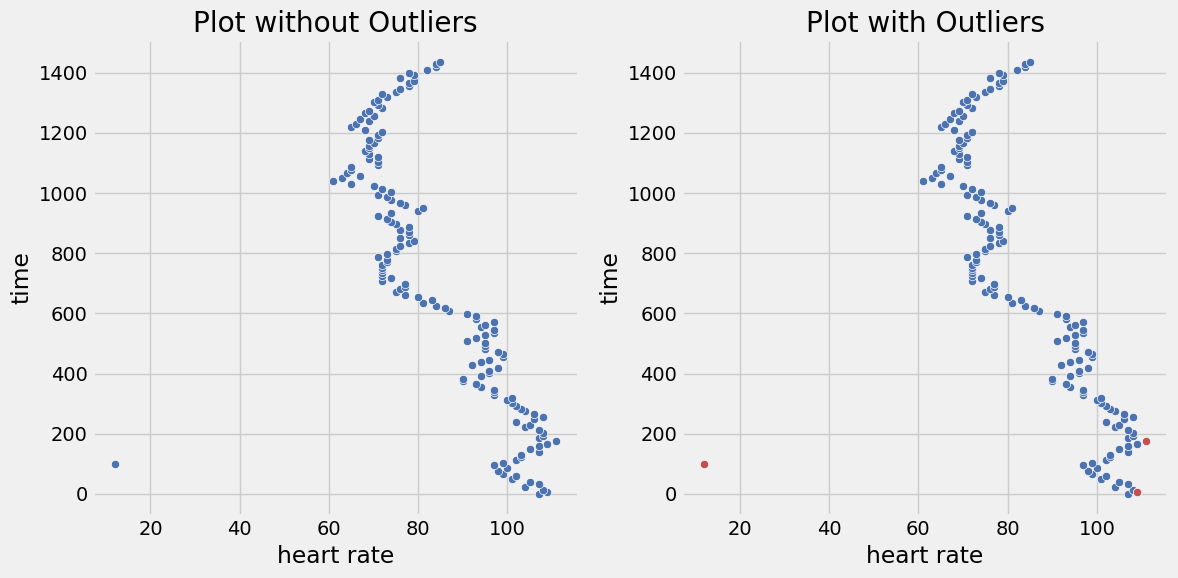

In [185]:
#detect the time of the outliers
outlier_time = []
for ele in outliers:
  inx = new_heart_rate.index(ele)
  outlier_time.append(new_time[inx])


#create the plots
with plt.style.context('fivethirtyeight'):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot without highlighting outliers
    sns.scatterplot(x=new_heart_rate, y=new_time, ax=axes[0], color='b')
    axes[0].set_xlabel('heart rate')
    axes[0].set_ylabel('time')
    axes[0].set_title('Plot without Outliers')

    # Plot with highlighting outliers
    sns.scatterplot(x=new_heart_rate, y=new_time, ax=axes[1], color='b')
    sns.scatterplot(x=outliers, y=outlier_time, ax=axes[1], color='r')
    axes[1].set_xlabel('heart rate')
    axes[1].set_ylabel('time')
    axes[1].set_title('Plot with Outliers')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# 9. Data Analysis

## 9.1 Checking for correlation between distance walked and heart rate

Research Question: Is there a correlation between the distance walked and heart rate?

**Null Hypothesis ($H_0$)**: There is no correlation between the distance walked and heart rate. Any observed correlation is due to random chance.

**Alternative Hypothesis ($H_A$)**: There is a correlation between the distance walked and heart rate. The correlation could be positive, indicating that as the distance walked increases, heart rate also increases, or negative, indicating that as the distance walked increases, heart rate decreases.

**Methodology** To test this, we will use Pearson's correlation coefficient. It helps measure any potential link, be it positive or negative, and how strong this link is.

To test for this hypothesis, we are going to collect the data, make the times match and see if there is correlation by calculating its p-value

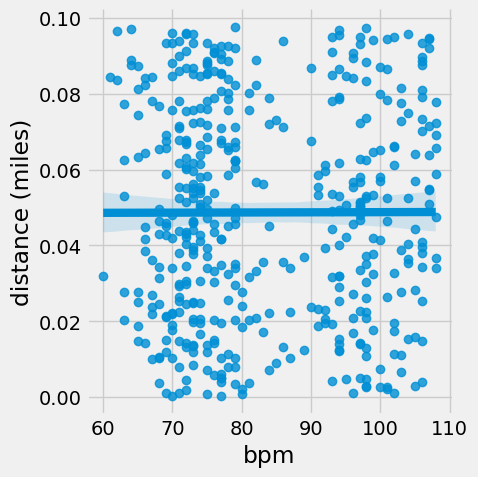

In [186]:
# first, let's collect the data

time_distances = []
distances = []

for datapoint in api_data['distance_day'][0]['activities-distance-intraday']['dataset']:
    distances.append(float(datapoint['value']))
    time_distances.append(int(datapoint['time'][0:2]) * 60 + int(datapoint['time'][3:5]))

time_heart = []
heart_rate = []

for datapoint in api_data['heart_rate_day'][0]['activities-heart-intraday']['dataset']:
    time_heart.append(int(datapoint['time'][0:2]) * 60 + int(datapoint['time'][3:5]))
    heart_rate.append(float(datapoint['value']))


#since all times are collected in distances but not heart rate we have fix this
#to get matching size arrays
new_dist = []
new_bpm = []

for i in range(len(distances)):
  if distances[i] != 0:
    if time_distances[i] in time_heart:
      new_dist.append(distances[i])
      new_bpm.append(heart_rate[time_heart.index(time_distances[i])])


#We remove the outliers after this
outliers1 = elliptic_envelope(new_dist)
outliers2 = elliptic_envelope(new_bpm)
for item in outliers1:
  if item in new_dist:
    index = new_dist.index(item)
    new_dist.remove(item)
    new_bpm.pop(index)
for item in outliers2:
  if item in new_bpm:
    index = new_bpm.index(item)
    new_bpm.remove(item)
    new_dist.pop(index)

# create a dataframex
d = {'distance (miles)': new_dist, 'bpm': new_bpm}
df = pd.DataFrame(data=d)

#plot the data
with plt.style.context('fivethirtyeight'):
    graph = sns.lmplot(data=df, y="distance (miles)", x="bpm")
    plt.show(block=True)

Now lets test the null hypothesis that heart rate does not increase as the distance walked increases. Looks like there is indeed a trend here, but an aggressive critic might argue that it could result from chance. To provide strong quantitative evidence in favor of our claim, which is that the null hypothesis is indeed false, we perform the Wald test, which addresses this setting precisely.


In [187]:
slope, intercept, r_value, p_value, std_err = stats.linregress(new_dist,new_bpm)
print(p_value)

0.9652791955761555


As we can see, the p-value, or the probability that assuming the slope is zero that we have obtained a slope of at least this magnitude, is extremely small <\.05, so this is a significant result and we can thus reject the null hypothesis that higher heart rates are not associated with higher distance walked.

## 9.2 Checking for Correlation Between the number of steps and distance covered in a day

Research Question: Is there a correlation between the distance covered and the number of steps taken?

**Null Hypothesis ($H_0$)**: There is no correlation between the distance covered and the number of steps taken. Any observed correlation is due to random chance.

**Alternate Hypothesis ($H_1$)**: There is a correlation between the distance covered and the number of steps taken. The correlation could be positive, indicating that as the number of steps increases, the distance covered also increases, or negative, indicating that as the number of steps increases, the distance covered decreases.

Methodology To test this, we will use Pearson's correlation coefficient. It helps measure any potential link, be it positive or negative, and how strong this link is.

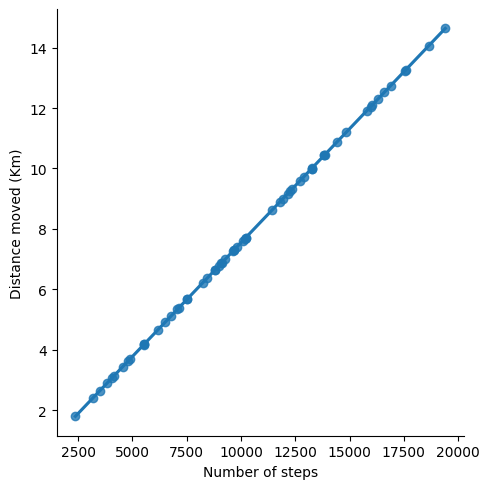

In [188]:
#First aggregate the data in arrays
dates_steps = []
steps = []
distance = []
dates_distance = []

for datapoint in api_data['steps'][0]['activities-steps']:
    dates_steps.append(datapoint['dateTime'])
    steps.append(float(datapoint['value']))

for datapoint in api_data['distance'][0]['activities-distance']:
    if datapoint['dateTime'] in dates_steps:
      distance.append(float(datapoint['value']))
      dates_distance.append(datapoint['dateTime'])


#since all times are collected in distances but not heart rate we have fix this
#to get matching size arrays
new_dist = []
new_steps = []

for i in range(len(distance)):
  if distance[i] != 0:
    if dates_distance[i] in dates_steps:
      new_dist.append(distance[i])
      new_steps.append(steps[dates_steps.index(dates_distance[i])])

# create a dataframex
d = {'Distance moved (Km)': new_dist, 'Number of steps': new_steps}
df = pd.DataFrame(data=d)

#plot the data
graph = sns.lmplot(data=df, y="Distance moved (Km)", x="Number of steps")
plt.show(block=True)


Now lets test the null hypothesis that the number of steps measured per day does not increase as the distance covered. Looks like there is indeed a trend here, but lets be precise.

In [189]:
slope, intercept, r_value, p_value, std_err = stats.linregress(distance,steps)
print(p_value)

0.0


A p-value of 0.0 indicates an extremely strong level of statistical significance. In this case, it suggests that there is a significant correlation between the distance covered and the number of steps taken. This means that the relationship between these two variables is unlikely to be due to random chance. This is actually true since the way they are calculated in the synthetic generator depends on each other!